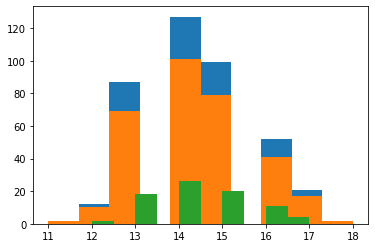

In [3]:
import numpy as np
import pandas as pd
import os
import os.path as op
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#%matplotlib
#%config IPCompleter.use_jedi = False

df = pd.read_csv('../data/parcels_FDG_tpm_ADNI.csv')

# modulo 7 works for both MRI and PET, 5 throws an error for PET
df['Age_bins'] = df['Age'].values // 5
df['Age_bins'] = df['Age_bins'].astype(int)

col = [x for x in df.columns if '_' in x]

X = df[col].values

y_pseudo = df['Age_bins']
y = df['Age']

x_train, x_test,  y_train, y_test, id_train, id_test = train_test_split(
    X, y, df['Subject'], test_size=.2, random_state=42,
    stratify=y_pseudo)

df['train'] = ["T" if x in id_train.values else "F" for x in df[
               'Subject']]


plt.hist(y_pseudo.values)
plt.hist(y_train // 5)
plt.hist(y_test // 5)
plt.show()

df.to_csv('../data/test_train_FDG_ADNI.csv')

Median:  73.0
[140 186]


c:\python\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Balanced accuracy rvr fold 0: 0.7
Balanced accuracy rvr fold 1: 0.67
Balanced accuracy rvr fold 2: 0.61
Balanced accuracy rvr fold 3: 0.7
Balanced accuracy rvr fold 4: 0.64
AVERAGE Balanced accuracy rvr: 0.66
Balanced accuracy svm fold 0: 0.5
Balanced accuracy svm fold 1: 0.5
Balanced accuracy svm fold 2: 0.5
Balanced accuracy svm fold 3: 0.5
Balanced accuracy svm fold 4: 0.5
AVERAGE Balanced accuracy svm: 0.5
Balanced accuracy rfc fold 0: 0.7
Balanced accuracy rfc fold 1: 0.64
Balanced accuracy rfc fold 2: 0.61
Balanced accuracy rfc fold 3: 0.68
Balanced accuracy rfc fold 4: 0.64
AVERAGE Balanced accuracy rfc: 0.65


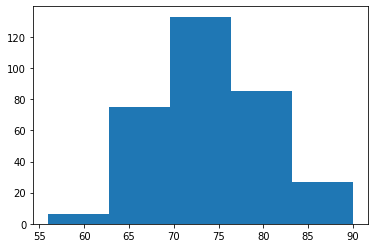

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats
# pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip
from skrvm import RVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from julearn import run_cross_validation
from julearn.utils import configure_logging
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn import plotting
from nilearn import image
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, confusion_matrix, balanced_accuracy_score
sys.path.append("../lib")
from create_splits import stratified_splits

df_train = df[df['train'] == "T"]

# Median split
med = np.median(df_train['Age'])
print("Median: ", med)
df_train['Age_bin'] = [0 if x< med else 1 for x in df_train['Age']]
print(np.bincount(df_train['Age_bin']))

df_train = df_train.reset_index(drop=True)
col = [x for x in df_train.columns if 'H_' in x]
plt.hist(df_train['Age'], bins=5)
c = col

rand_seed = 42
num_bins = 5
rvm = RVC()
svm = SVC()
rfc = RandomForestClassifier()
models = [rvm, svm, rfc]
model_names = ['rvr', 'svm', 'rfc']
splits = 5

model_results = []
scores_results = []
res = {}

res['model'] = []
res['iter'] = []
res['pred'] = []
res['real'] = []
res['ind'] = []

for i, model in enumerate(models):
    cv = StratifiedKFold(n_splits=splits).split(df_train[c],
                                                df_train['Age_bins'])
    cv = list(cv)
    scores, final_model = run_cross_validation(X=c, y='Age_bin',
                                         # preprocess_X='scaler_robust',
                                         data=df_train,
                                         model=model, cv=cv,
                                         return_estimator='all',
                                         seed=rand_seed,
                                         scoring=['accuracy'])
    model_results.append(final_model)
    scores_results.append(scores)
    for iter in range(splits):
        pred = scores.estimator[iter].predict(df_train.iloc[cv[iter][1]][c])
        real = df_train.iloc[cv[iter][1]]['Age_bin'].tolist()
        res['pred'].append(pred)
        res['real'].append(real)
        res['iter'].append(iter)
        res['model'].append(str(model))
        res['ind'].append(cv[iter][1])

    df_res = pd.DataFrame(res)

for m in models:
    ba = []
    y_true = df_res['real'][df_res['model'] == str(m)].tolist()
    y_pred = df_res['pred'][df_res['model'] == str(m)].tolist()
    for s in range(splits):
        ba.append(np.round(balanced_accuracy_score(y_true[s], y_pred[s]),2))
        print("Balanced accuracy {} fold {}: {}".format(model_names[models.index(m)], s, ba[s]))
    print("AVERAGE Balanced accuracy {}: {}".format(model_names[models.index(m)], np.round(np.mean(ba),2)))